In [14]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import builtins
builtins.NAMING = "new"


from plotting_src.header_settings import *
from plotting_src.read_ggp_run import * 
from simulations.cells_simulation import * 

from plotting_src.cells_utils import *
from plotting_src.read_utils import *


%config InlineBackend.figure_format ='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
input_dir =     "../../fluctuations_paper_data/mother_machine_data_sets/"
prediction_files = get_input_files(input_dir, keyword="prediction")
prediction_files[0]

'../../fluctuations_paper_data/mother_machine_data_sets/acetate005_hi1_20230228_autofl_corrected_f01234578910_b_prediction.csv'

In [ ]:
def get_metas(prediction_files):
    prediction_files = sorted(prediction_files)
    samples = pd.DataFrame(index=prediction_files, columns=["date", "sample", "promoter", "condition", "replicate"])
    for pf in prediction_files:
        sample = "_".join(pf.split("/")[-1].split(".")[0].split("_")[:3])
        samples.loc[pf,"sample"] = sample
        samples.loc[pf,"condition"] = sample.split("_")[0]
        samples.loc[pf,"promoter"] = sample.split("_")[1]
        samples.loc[pf,"date"] = sample.split("_")[2]

    condition_promoter_tuples = []
    for pf in prediction_files:
        condition_promoter_tuple = "_".join(samples.loc[pf,"sample"].split("_")[:2])
        if condition_promoter_tuple in condition_promoter_tuples:
            samples.loc[pf,"replicate"] = "2"
        else:
            samples.loc[pf,"replicate"] = "1"
        condition_promoter_tuples.append(condition_promoter_tuple)

    return samples.to_dict('index')


def get_integration_file(pf, setting):
    parent_dir = os.path.join(*pf.split("/")[:-1])
    sample = '_'.join(pf.split('/')[-1].split('_')[:3])

    return os.path.join(*parent_dir.split("/")[:-1], "integration",sample, setting, sample+"_"+setting+'.csv')


def calc_log_concentration(cells):
    for i, cell in enumerate(cells):
        c = cell.gfp/np.exp(cell.log_length)
        if np.any(c<0):
            print(c)
        cells[i].log_concentration = np.log(c)
        cells[i].log1_concentration = np.log(c+1)
        cells[i].concentration = c
    return cells


def get_mean_growth_rate(cells):
    mean_lambda = np.sum(np.concatenate([np.array(cell.lt)/np.array(cell.cov_ll) for cell in cells])) \
                /np.sum(np.concatenate([1./np.array(cell.cov_ll) for cell in cells]))
    return mean_lambda


def get_cells(samples):
    for pf in samples.keys():
        print(pf.split("/")[-1])

        samples[pf]["cells"] = calc_log_concentration(ggp_df2cells(read_ggp_csv(pf)))
        samples[pf]["mean_growth_rate"] = get_mean_growth_rate(samples[pf]["cells"])

        for s in ["no_div_noise", "1",'0.5', '0.25', '0.125', '0.0625', '0.03125', '0.015625', '0.0078125', "0.00390625"]:

        # for s in ["no_div_noise", "1", "0.32", "0.1", "0.032", "0.01", "0.0032", "0.001"]:

            samples[pf]["cells_"+s] = calc_log_concentration(df2cells(read_ggp_csv(get_integration_file(pf, s))))

    return samples

samples = get_metas(prediction_files)
samples = get_cells(samples)

In [4]:
def filter_dict(samples, filter_key=None):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        if filter_key in sample_name:
            new_samples[pf] = samples[pf]
    return new_samples

def filter_dict_not(samples, *filter_keys):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        remove = np.any([filter_key in sample_name for filter_key in filter_keys])
        if not remove:
            new_samples[pf] = samples[pf]
    return new_samples

def get_replicate(samples, repl="1"):
    new_samples = {}
    for pf in samples.keys():
        
        if samples[pf]["replicate"] == repl :
            new_samples[pf] = samples[pf]
    return new_samples

first_replicates = filter_dict_not(get_replicate(samples), "6300") 


In [5]:
def is_first_cell_in_lineage(cell, cells):
    pid = cell.parent_id
    for c in cells:
        if c.cell_id == pid:
            return False
    return True


############# get * concentrations  #############
def get_log_concentrations(cells):
    return np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

def get_log1_concentrations(cells):
    return np.concatenate([cell.log1_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

def get_finite_log_concentrations(cells):
    lc = np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return lc[np.isfinite(lc)]

def get_concentrations(cells):
    return np.concatenate([ cell.concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

############# get log gfp  #############
def get_finite_log_gfp(cells):
    g = np.concatenate([np.log(cell.gfp) for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return g[np.isfinite(g)]


############# get gfp  #############
def get_gfp(cells):
    g = np.concatenate([cell.gfp for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return g

############# get concentration std  #############
def get_concentration_std(cells):
    return np.std( get_concentrations(cells) )

### Label
def get_q_scale_label(s):
    label = { s: r"$1/2^{:d}$".format(i+1) for i,s in enumerate(['0.5', '0.25', '0.125', '0.0625', '0.03125', '0.015625', '0.0078125', '0.00390625'])}
    label['1'] = '1'
    s = s.split("_")[-1]
    return r"$\mu_q$=" + label[s]

In [6]:
[1/2**i for i in range(1,8)]

[0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]

In [7]:


# alpha_by_setting = {"cells_"+s: i*0.1 +0.2 for i,s in enumerate(["1", "0.32", "0.1", "0.032", "0.01", "0.0032", "0.001"])}
alpha_by_setting = {"cells_"+s: i*0.1 +0.15 for i,s in enumerate(["1", '0.5', '0.25', '0.125', '0.0625', '0.03125', '0.015625', '0.0078125', "0.00390625"])}

alpha_by_setting

{'cells_1': 0.15,
 'cells_0.5': 0.25,
 'cells_0.25': 0.35,
 'cells_0.125': 0.45000000000000007,
 'cells_0.0625': 0.55,
 'cells_0.03125': 0.65,
 'cells_0.015625': 0.7500000000000001,
 'cells_0.0078125': 0.8500000000000001,
 'cells_0.00390625': 0.9500000000000001}

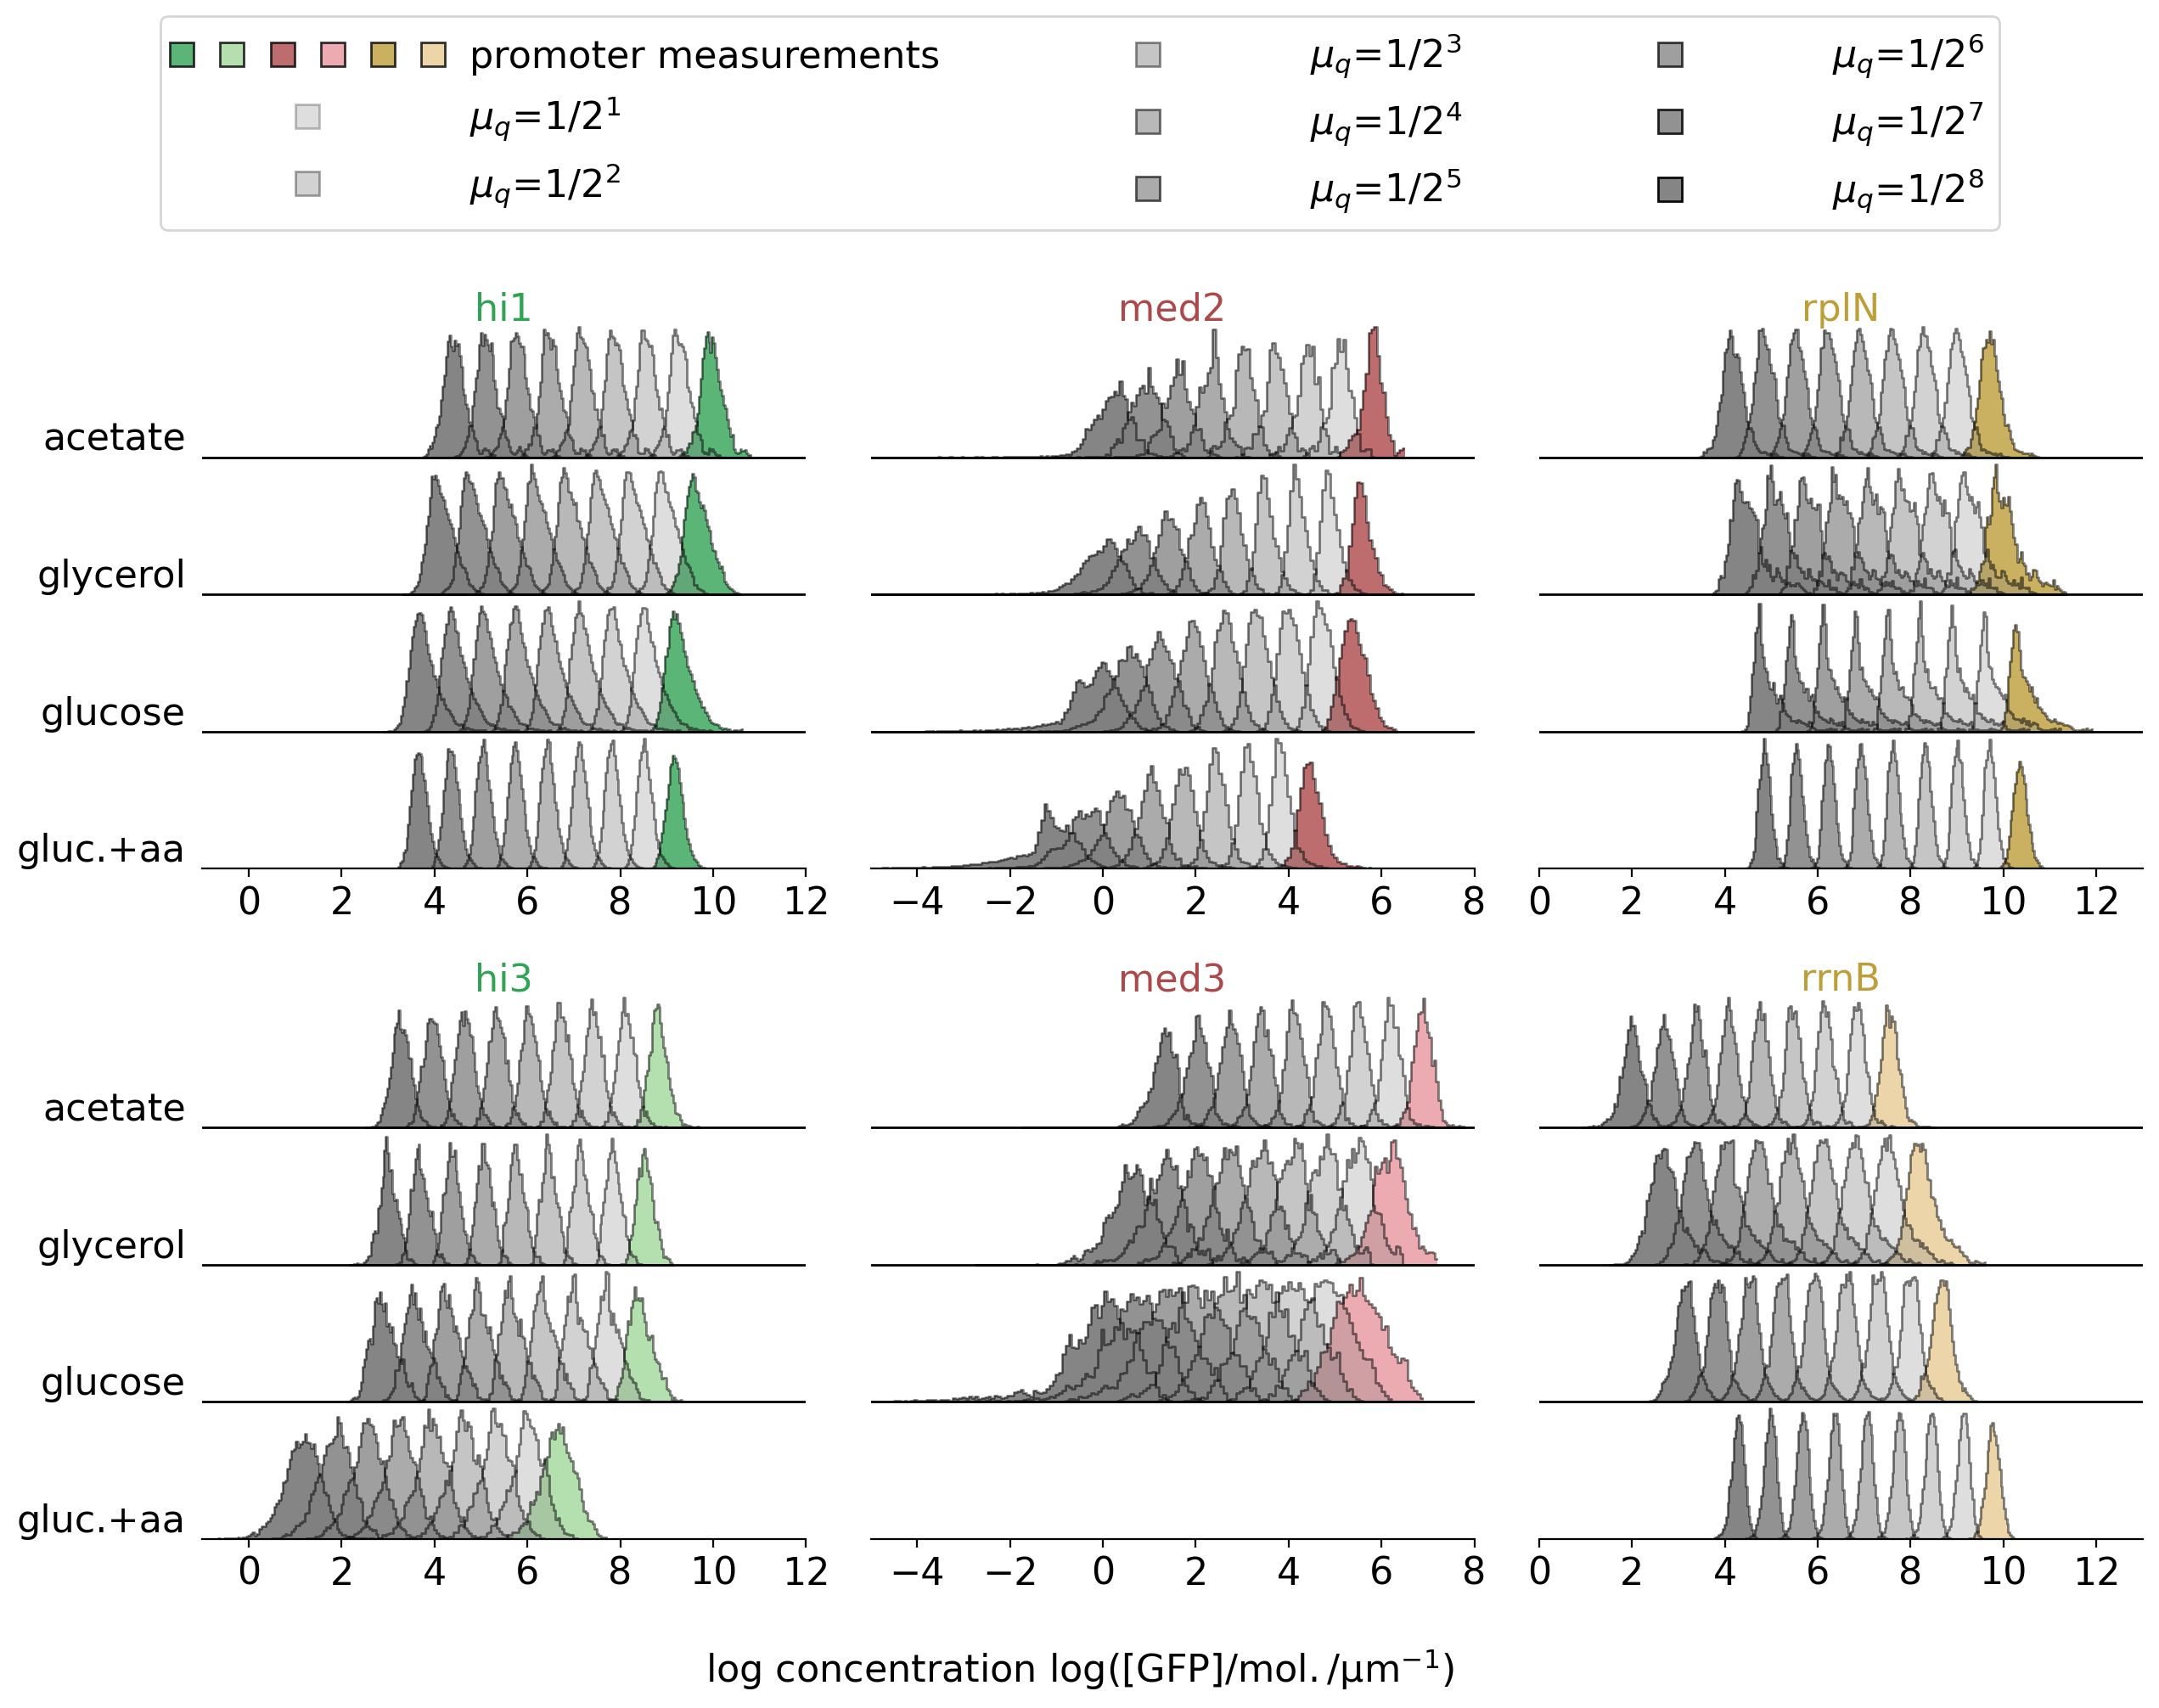

In [8]:
def plot_log_concentration_histograms_v(samples, hist_width=1, bins=30, plot_file=None, noise_settings=[]):
    fig, axes = plt.subplots(2, 3, figsize=(FULL_SIZE, FULL_SIZE*2/3), sharex=False, sharey=True)
    ax = axes.transpose().ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["left"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.spines['left'].set_color('none')
        a.yaxis.tick_left()
        a.yaxis.set_ticks_position('none') 

    ax[0].get_shared_x_axes().join(ax[0], ax[1])
    ax[2].get_shared_x_axes().join(ax[2], ax[3])
    ax[4].get_shared_x_axes().join(ax[4], ax[5])


    condition_xtick = {cond: m for cond,m  in zip(conditions, np.arange(4)[::-1])}

    for i, promoter in enumerate(promoters):
        for sample in samples.keys():
            if samples[sample]["promoter"] != promoter:
                continue
            color = color_by_promoter[samples[sample]["promoter"]]
            ###
            all_conc = np.concatenate([get_finite_log_concentrations(samples[sample][s]) for s in noise_settings])
            bins = np.linspace(np.min(all_conc), np.max(all_conc), 200)

            bins_list = []
            edges_list = []
            for s in noise_settings:
                b, e = np.histogram(get_finite_log_concentrations(samples[sample][s]), bins=bins)
                bins_list.append(b)
                edges_list.append(e)
            ###
            bin_norm = np.max([np.max(b) for b in bins_list])
            for j, b in enumerate(bins_list):
                bins_list[j]=b/bin_norm*hist_width

            # x = samples[sample]["mean_growth_rate"]*60
            x = condition_xtick[samples[sample]["condition"]]
            ax[i].bar(edges_list[0][:-1] + np.diff(edges_list[0]), bins_list[0], np.diff(edges_list[0]), bottom=x, lw = 2, alpha=0.8, color=color)
            ax[i].step(edges_list[0][:-1] + np.diff(edges_list[0]), x+bins_list[0], where="mid",  lw = 1, alpha=0.5, color="black")


            # ax[i].bar(edges_list[1][:-1] + np.diff(edges_list[1]), bins_list[1], np.diff(edges_list[1]), bottom=x, lw = 2, alpha=0, color="None")
            # ax[i].step(edges_list[1][:-1] + np.diff(edges_list[1]), x+bins_list[1], where="mid",  lw = 1, alpha=0.5, color="black")


       

            for j, s in enumerate(noise_settings):
                if s== "cells" or s=="cells_no_div_noise":
                    continue
                ax[i].bar(edges_list[j][:-1] + np.diff(edges_list[j]), bins_list[j], np.diff(edges_list[j]), bottom=x, lw = 2, alpha=alpha_by_setting[s], color="tab:grey")
                ax[i].step(edges_list[j][:-1] + np.diff(edges_list[j]), x+bins_list[j], where="mid",  lw = 1, alpha=0.5, color="black")
        

            ax[i].axhline(x, lw=1, color="black", alpha=1)
            ax[i].set_yticks([])
            ax[i].set_title(promoter, y=0.94, color=color_by_promoter_cat[promoter])
            ax[i].set_yticks(np.arange(4)[::-1], )
            ax[i].set_yticklabels( conditions_labels, fontdict={'verticalalignment':"bottom"})
            ax[i].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=2))


    ax[0].set_xlim([-1, 12])
    ax[2].set_xlim([-5, 8])
    ax[4].set_xlim([-0, 13])

    colors_for_legend1 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color=color_by_promoter[k],
                                        alpha=0.8, 
                                        markersize=10,
                                        marker='s',
                                        linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]
    
    colors_for_legend2 = [mlines.Line2D([], [],  alpha=alpha_by_setting[s], 
                                        markersize=10,
                                        marker='s',
                                       linestyle='None',
                                       markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                       color='tab:grey', 
                                       label=get_q_scale_label(s)) for s in noise_settings if s in alpha_by_setting.keys() ]
    
    colors_for_legend3 = [mlines.Line2D([], [], 
                                        markersize=10,
                                        color="None", 
                                        markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        marker='s',linestyle='None', label=l) for l in ["no div. noise"]]
    
    from matplotlib.legend_handler import HandlerTuple
    # l = fig.legend([ tuple(colors_for_legend1),
    #                 tuple(colors_for_legend3)]+
    #                 [(c,) for i,c in enumerate(colors_for_legend2)] , 
    #                ['promoter measurements'] +["no div. noise"]+ [get_q_scale_label(s) for s in noise_settings if s in alpha_by_setting.keys()] ,
    #                 handler_map={tuple: HandlerTuple(ndivide=None, pad=1)}, 
    #                 bbox_to_anchor=(0.5, 1), 
    #                 loc="lower center", 
    #                 ncol=4, 
    #                 scatterpoints = len(promoters), 
    #                 scatteryoffsets = [.5], handlelength = len(promoters)+1)  

    l = fig.legend([ tuple(colors_for_legend1) ]+
                    [(c,) for i,c in enumerate(colors_for_legend2)] , 
                   ['promoter measurements'] + [get_q_scale_label(s) for s in noise_settings if s in alpha_by_setting.keys()] ,
                    handler_map={tuple: HandlerTuple(ndivide=None, pad=1)}, 
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", 
                    ncol=3, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], handlelength = len(promoters)+1)  
    
    fig.supxlabel("log concentration log([GFP]$/\mathrm{mol. /\mu m^{-1}}$)", y=0.02)

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()


# setting_to_compare = ["cells"]+["cells_"+s for s in ["0.32", "0.1", "0.032", "0.01", "0.0032"]]
setting_to_compare = ["cells"]+["cells_"+s for s in ['0.5', '0.25', '0.125', '0.0625', '0.03125', '0.015625', '0.0078125', "0.00390625"]]
    
plot_log_concentration_histograms_v(first_replicates, hist_width=0.95, 
                                    noise_settings=setting_to_compare,
                                    plot_file="../../figures_for_fluctuations_paper/supp/downscaling_hist.pdf")



In [9]:
s0=list(samples.keys())[0]
samples[s0].keys()

dict_keys(['date', 'sample', 'promoter', 'condition', 'replicate', 'cells', 'mean_growth_rate', 'cells_no_div_noise', 'cells_1', 'cells_0.5', 'cells_0.25', 'cells_0.125', 'cells_0.0625', 'cells_0.03125', 'cells_0.015625', 'cells_0.0078125', 'cells_0.00390625'])

In [10]:
### Statistics
#### concentration
def get_mean_concentration(cells):
    return np.mean(get_concentrations(cells))

def get_log_concentration_mean(cells):
    return np.mean( get_finite_log_concentrations(cells) )

def get_log_concentration_std(cells):
    return np.std( get_finite_log_concentrations(cells) )


def get_log_concentration_iqr(cells):
    return estimate_iqr( get_finite_log_concentrations(cells) )

def get_log_gfp_mean(cells):
    return np.mean( get_finite_log_gfp(cells) )


def estimate_iqr(c):
    return np.subtract(*np.percentile(c, [75, 25]))


#### gfp
def get_mean_division_gfp(cells):
    g = []
    for cell in cells:
        g.append(cell.gfp[-1])
    return np.mean(g)

def get_gfp_mean(cells):
    return np.mean( get_gfp(cells) )


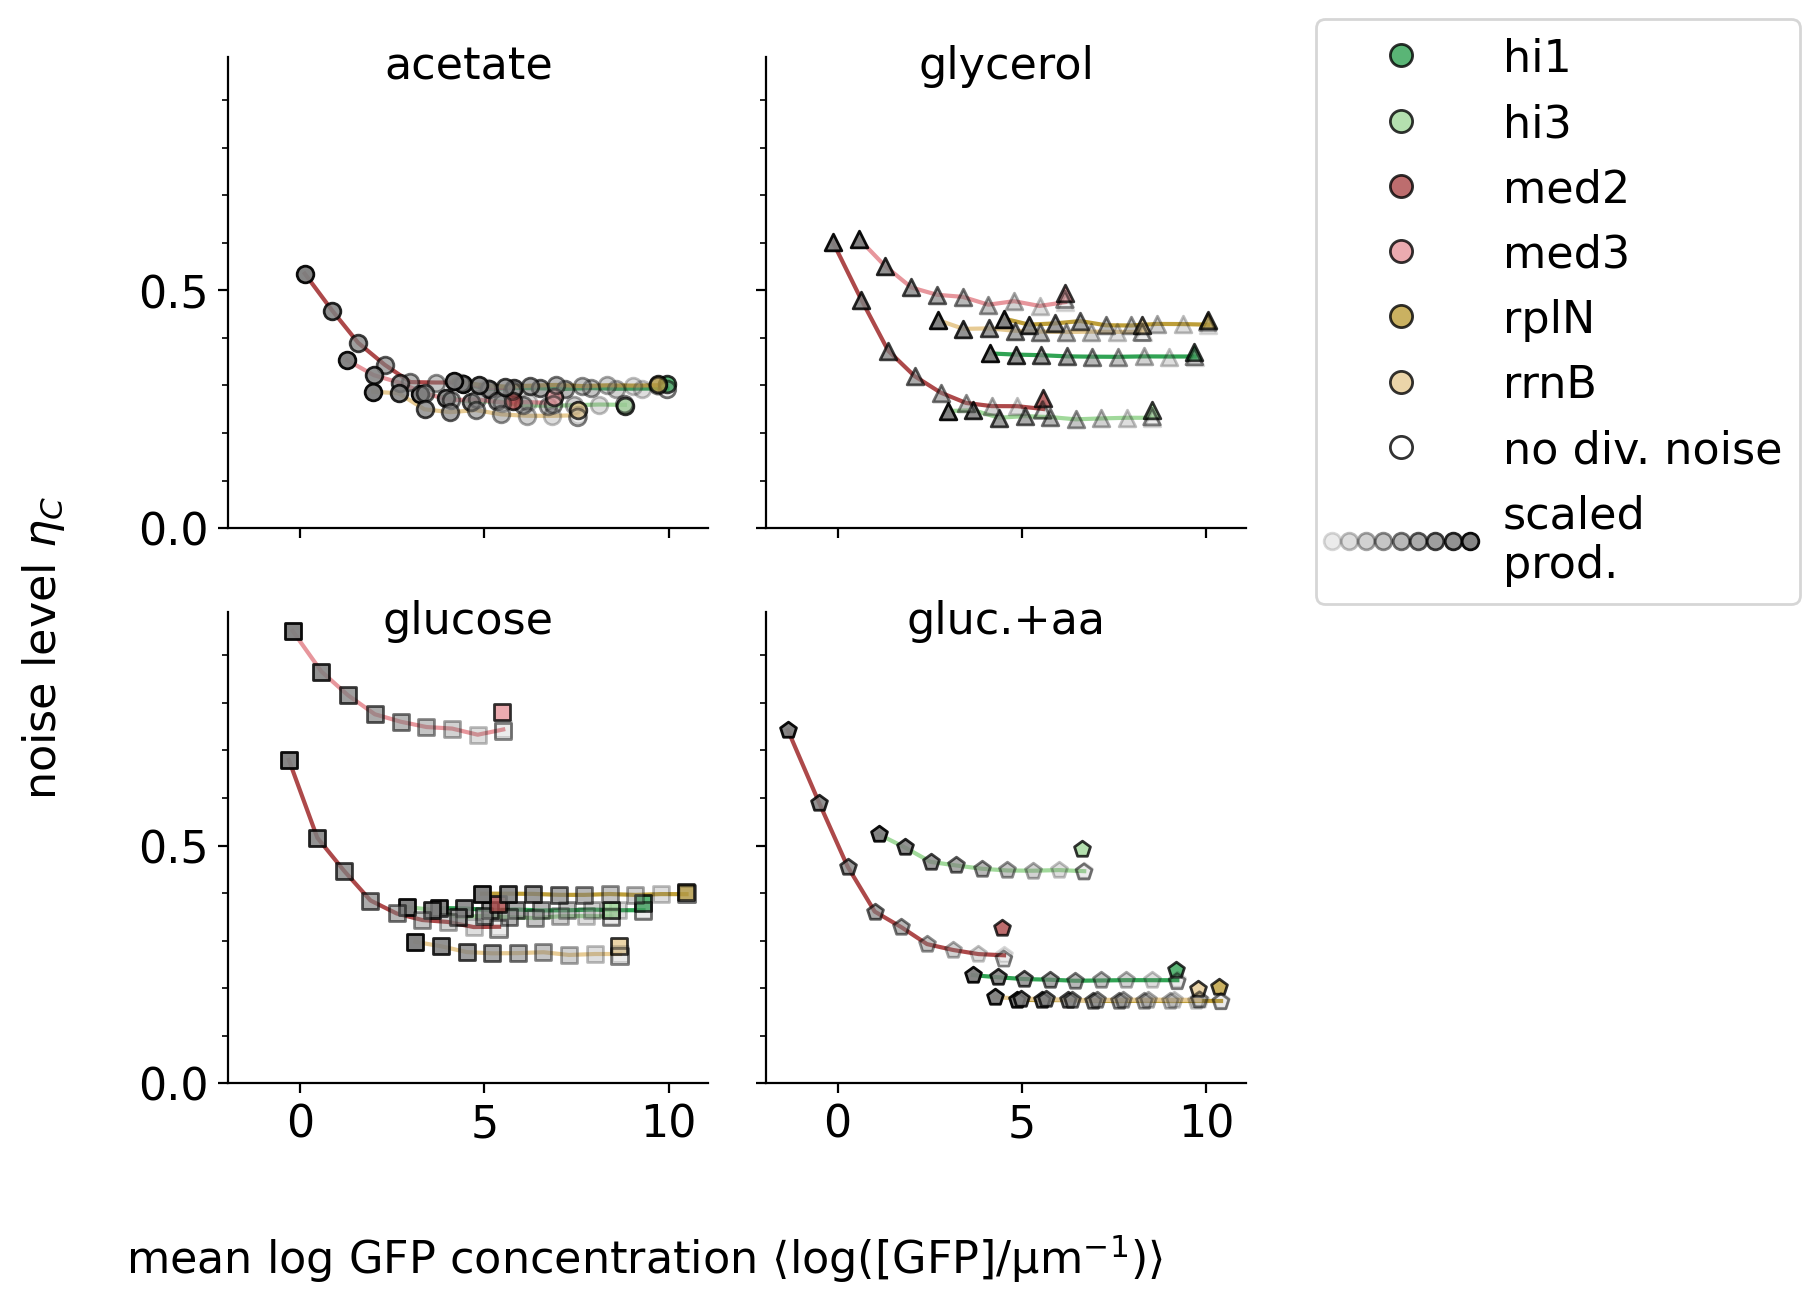

In [11]:
def plot_log_concentration_iqr_single(samples, noise_settings=[], plot_file=None):
    fig, axes = plt.subplots(2, 2, figsize=(FULL_SIZE/2, FULL_SIZE/2), sharey=True, sharex=True)
    ax = axes.ravel()
    # remove the underlying axes

  
    for a in list(ax):
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)
        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

    
    all_mean_gfp = np.array([])
    all_delta_iqr = np.array([])

    for i, condition in enumerate(conditions):
        for sample in samples.keys():
            if samples[sample]["condition"] != condition:
                continue
            color = color_by_promoter[samples[sample]["promoter"]]
            marker = marker_by_condition[samples[sample]["condition"]]
            ###
           
            if condition == conditions[-1] and samples[sample]["promoter"]=="med3" :
                noise_settings = noise_settings

            else:
                noise_settings = noise_settings
            # noise_settings = noise_settings
            
            iqrs=[]
            log_gfp_means=[]
            log_concentration_mean = []

            for j, s in enumerate(noise_settings):    
                iqrs.append(get_log_concentration_iqr(samples[sample][s]))
                log_gfp_means.append(get_gfp_mean(samples[sample][s]))
                log_concentration_mean.append(get_log_concentration_mean(samples[sample][s]))


            for j, s in enumerate(noise_settings):       
                if j==0:
                    ax[i].scatter(log_concentration_mean[j], iqrs[j], alpha=0.8, 
                                  color=color, ec=list(mcolors.to_rgb('black')) + [0.5], marker=marker)
                elif j==1:
                    ax[i].scatter(log_concentration_mean[j], iqrs[j], 
                                  color="None", ec=list(mcolors.to_rgb('black')) + [0.5], 
                                  label="no div. noise", marker=marker)
                else:
                    ax[i].scatter(log_concentration_mean[j], iqrs[j], alpha=alpha_by_setting[s], 
                                  color="tab:grey", ec=list(mcolors.to_rgb('black')) + [0.5], 
                                   marker=marker) #label=get_q_scale_label(s),
        
            ax[i].plot(log_concentration_mean[2:], iqrs[2:], color=color, alpha=1, zorder=-1, 
                                  label=samples[sample]["promoter"])
            ax[i].set_title(label_by_condition[condition], y=0.92)

            ax[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
            ax[i].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))
            
            #######    
            delta = np.add(iqrs, - iqrs[1])
            all_mean_gfp = np.append(all_mean_gfp, log_gfp_means[2:])
            all_delta_iqr = np.append(all_delta_iqr, delta[2:])
        
    # === Legend ===
    from matplotlib.legend_handler import HandlerTuple

    colors_for_legend2 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color=color_by_promoter[k],alpha=0.8, markersize=8,marker='o',linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]

    colors_for_legend1 = [mlines.Line2D([], [],  alpha=alpha_by_setting[s], 
                                        markersize=6,
                                        marker='o',
                                       linestyle='None',
                                       markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                       color='tab:grey', 
                                       label=get_q_scale_label(s)) for s in noise_settings if s in alpha_by_setting.keys() ]

    colors_for_legend3 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color="None",alpha=0.8, markersize=8,marker='o',linestyle='None',
                                        label=k) for k in ['1']]

    l = fig.legend([tuple(colors_for_legend2[i:i+1]) for i in range(6)] + [tuple(colors_for_legend3[:1])] + [tuple(colors_for_legend1)], 
                    promoters+ ["no div. noise"] + ['scaled\nprod.'],
                    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
                    # bbox_to_anchor=(1,0.5), 
                    bbox_to_anchor=(1, 1), 
                    # loc="center left", 
                    loc="upper left", 
                    ncol=1, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], handlelength = 3)   
    
    
    ## Layout ##
    ax[0].set_ylim(0)   

    fig.supxlabel(r"mean log GFP concentration $\langle\log(\mathrm{[GFP]/\mu m^{-1}})\rangle$")    
    fig.supylabel(r"noise level $\eta_C$")

    ## save ##
    plt.tight_layout()
    # fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()

setting_to_compare = ["cells"]+["cells_"+s for s in ["no_div_noise", "1" , '0.5', '0.25', '0.125', '0.0625', '0.03125', '0.015625', '0.0078125', '0.00390625']]
plot_log_concentration_iqr_single(first_replicates, noise_settings=setting_to_compare[:])
                                # plot_file="../../figures_for_fluctuations_paper/downscaling_IQR_single.pdf")


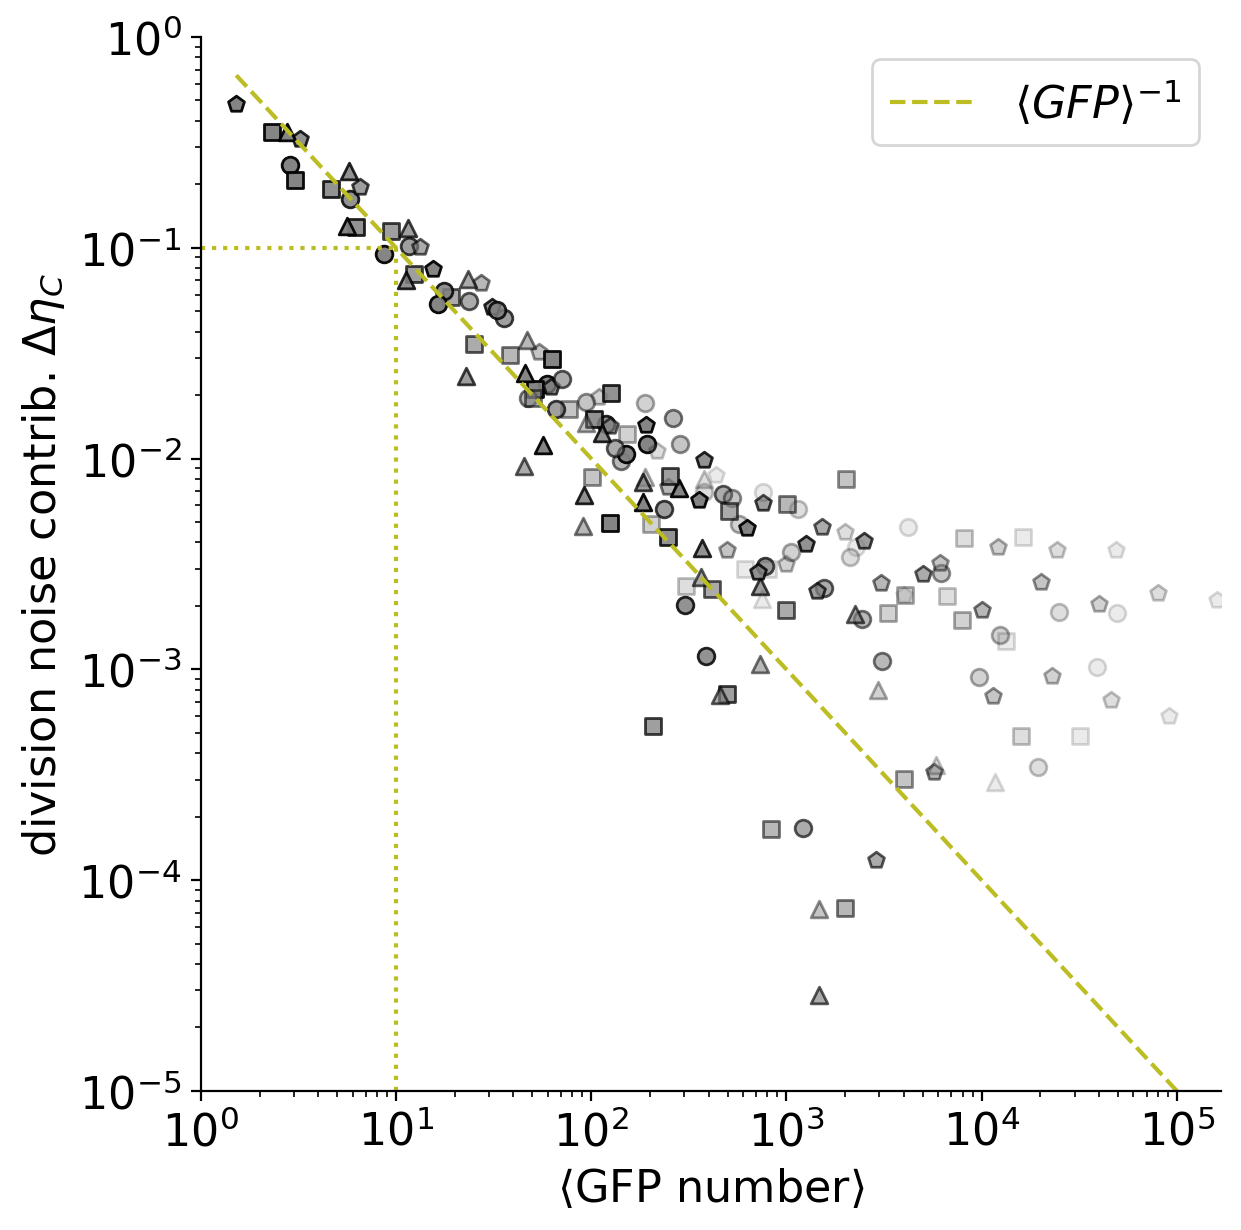

In [12]:

def power_law(x, a,b):
    return a*x**(-b) 

def power_law_fit(x,y):
    popt, pcov = scipy.optimize.curve_fit(power_law, x, y,  p0 = np.asarray([1, 1]),  maxfev=2000 )
    return popt, pcov 

def plot_log_concentration_iqr_collapse(samples, noise_settings=[], x_stat_func=get_log_gfp_mean, xlabel=None, logx=False, plot_file=None):
    fig, ax = plt.subplots( figsize=(FULL_SIZE/2,FULL_SIZE/2))
    # ax = ax.transpose().ravel()
    
    for a in [ax]:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()


    all_x_stat = np.array([])
    all_delta_iqr = np.array([])
    for i, promoter in enumerate(promoters):
        for sample in samples.keys():
            if samples[sample]["promoter"] != promoter:
                continue
            color = color_by_promoter[samples[sample]["promoter"]]
            ###
           
            iqrs=[]
            x_stats=[]
            for j, s in enumerate(noise_settings):       
                iqr = get_log_concentration_iqr(samples[sample][s])
                x_stat = x_stat_func(samples[sample][s])
                iqrs.append(iqr)
                x_stats.append(x_stat)

            delta = np.add(iqrs, - iqrs[1])

            for j, s in enumerate(noise_settings):       
                if j==0:
                    # ax.scatter(x_stats[j], iqrs[j], alpha=0.8, color=color, 
                               # ec=list(mcolors.to_rgb('black')) + [0.5], label=samples[sample]["promoter"])
                    pass
                elif j==1:
                    pass
                    # ax.scatter(x_stats[j], iqrs[j], color="None", 
                               # ec=list(mcolors.to_rgb('black')) + [0.5], label="no div. noise")
                else:
                    ax.scatter(x_stats[j], delta[j], 
                               alpha=alpha_by_setting[s], 
                               color="tab:grey", 
                               ec=list(mcolors.to_rgb('black')) + [0.5], 
                               marker=marker_by_condition[samples[sample]["condition"]])

            all_x_stat = np.append(all_x_stat, x_stats[2:])
            all_delta_iqr = np.append(all_delta_iqr, delta[2:])
                    
    g0 = all_delta_iqr>0
    all_x_stat = all_x_stat[g0]
    all_delta_iqr = all_delta_iqr[g0]

    popt,_ =power_law_fit(all_x_stat, all_delta_iqr) 

    ax.set_ylim(np.min(all_delta_iqr), np.max(all_delta_iqr))
    ax.set_xlim(1, None)
    
    # ax.plot(np.NaN, np.NaN, label=r"$a \times \langle GFP \rangle ^{-b}$",color="None")
    
    # ax.plot(all_x_stat[np.argsort(all_x_stat)], 
    #            power_law(all_x_stat[np.argsort(all_x_stat)], *popt),
    #            ls='-',
    #             color="tab:olive",
            # label=r"$a=${:.2f}, $b=${:.2f}".format(*popt))
    
    ax.plot(all_x_stat[np.argsort(all_x_stat)], 
           power_law(all_x_stat[np.argsort(all_x_stat)], 1,1),
           ls='--',
            color="tab:olive",label=r"$\langle GFP \rangle ^{-1}$")
        
    if logx:
        ax.set_xscale("log")

    ax.set_yscale("log")
    
    ax.set_xticks([10.**i for i in np.arange(0, 6)])
    ax.set_yticks([10.**i for i in np.arange(-5, 1)])
    
    ax.hlines(1/10, ax.set_xlim()[0], 10, ls=':', color="tab:olive")
    ax.vlines(10, ax.set_ylim()[0], 1/10, ls=':', color="tab:olive")
    
    ax.legend(bbox_to_anchor=(1,1), loc="upper right")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"division noise contrib. $\Delta \eta_C$")

    plt.tight_layout()
    # fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')

    plt.show()

setting_to_compare = ["cells"]+["cells_"+s for s in ["no_div_noise", "1" , '0.5', '0.25', '0.125', '0.0625', '0.03125', '0.015625', '0.0078125', '0.00390625']]
# plot_log_concentration_iqr_collapse(first_replicates, noise_settings=setting_to_compare, 
#                                     x_stat_func=get_log_concentration_mean, 
#                                     xlabel=r"$\langle$log [GFP]$\rangle$")

# plot_log_concentration_iqr_collapse(first_replicates, noise_settings=setting_to_compare, 
#                                     x_stat_func=get_mean_division_gfp,
#                                     xlabel=r"$\langle$GFP number at division$\rangle$", logx=True,
#                                     plot_file="../../figures_for_fluctuations_paper/downscaling_IQR_mean_GFP_at_div.pdf")

plot_log_concentration_iqr_collapse(first_replicates, noise_settings=setting_to_compare, 
                                    x_stat_func=get_gfp_mean, 
                                    xlabel=r"$\langle$GFP number$\rangle$", logx=True)
                                    # plot_file="../../figures_for_fluctuations_paper/downscaling_IQR_collapse.pdf")



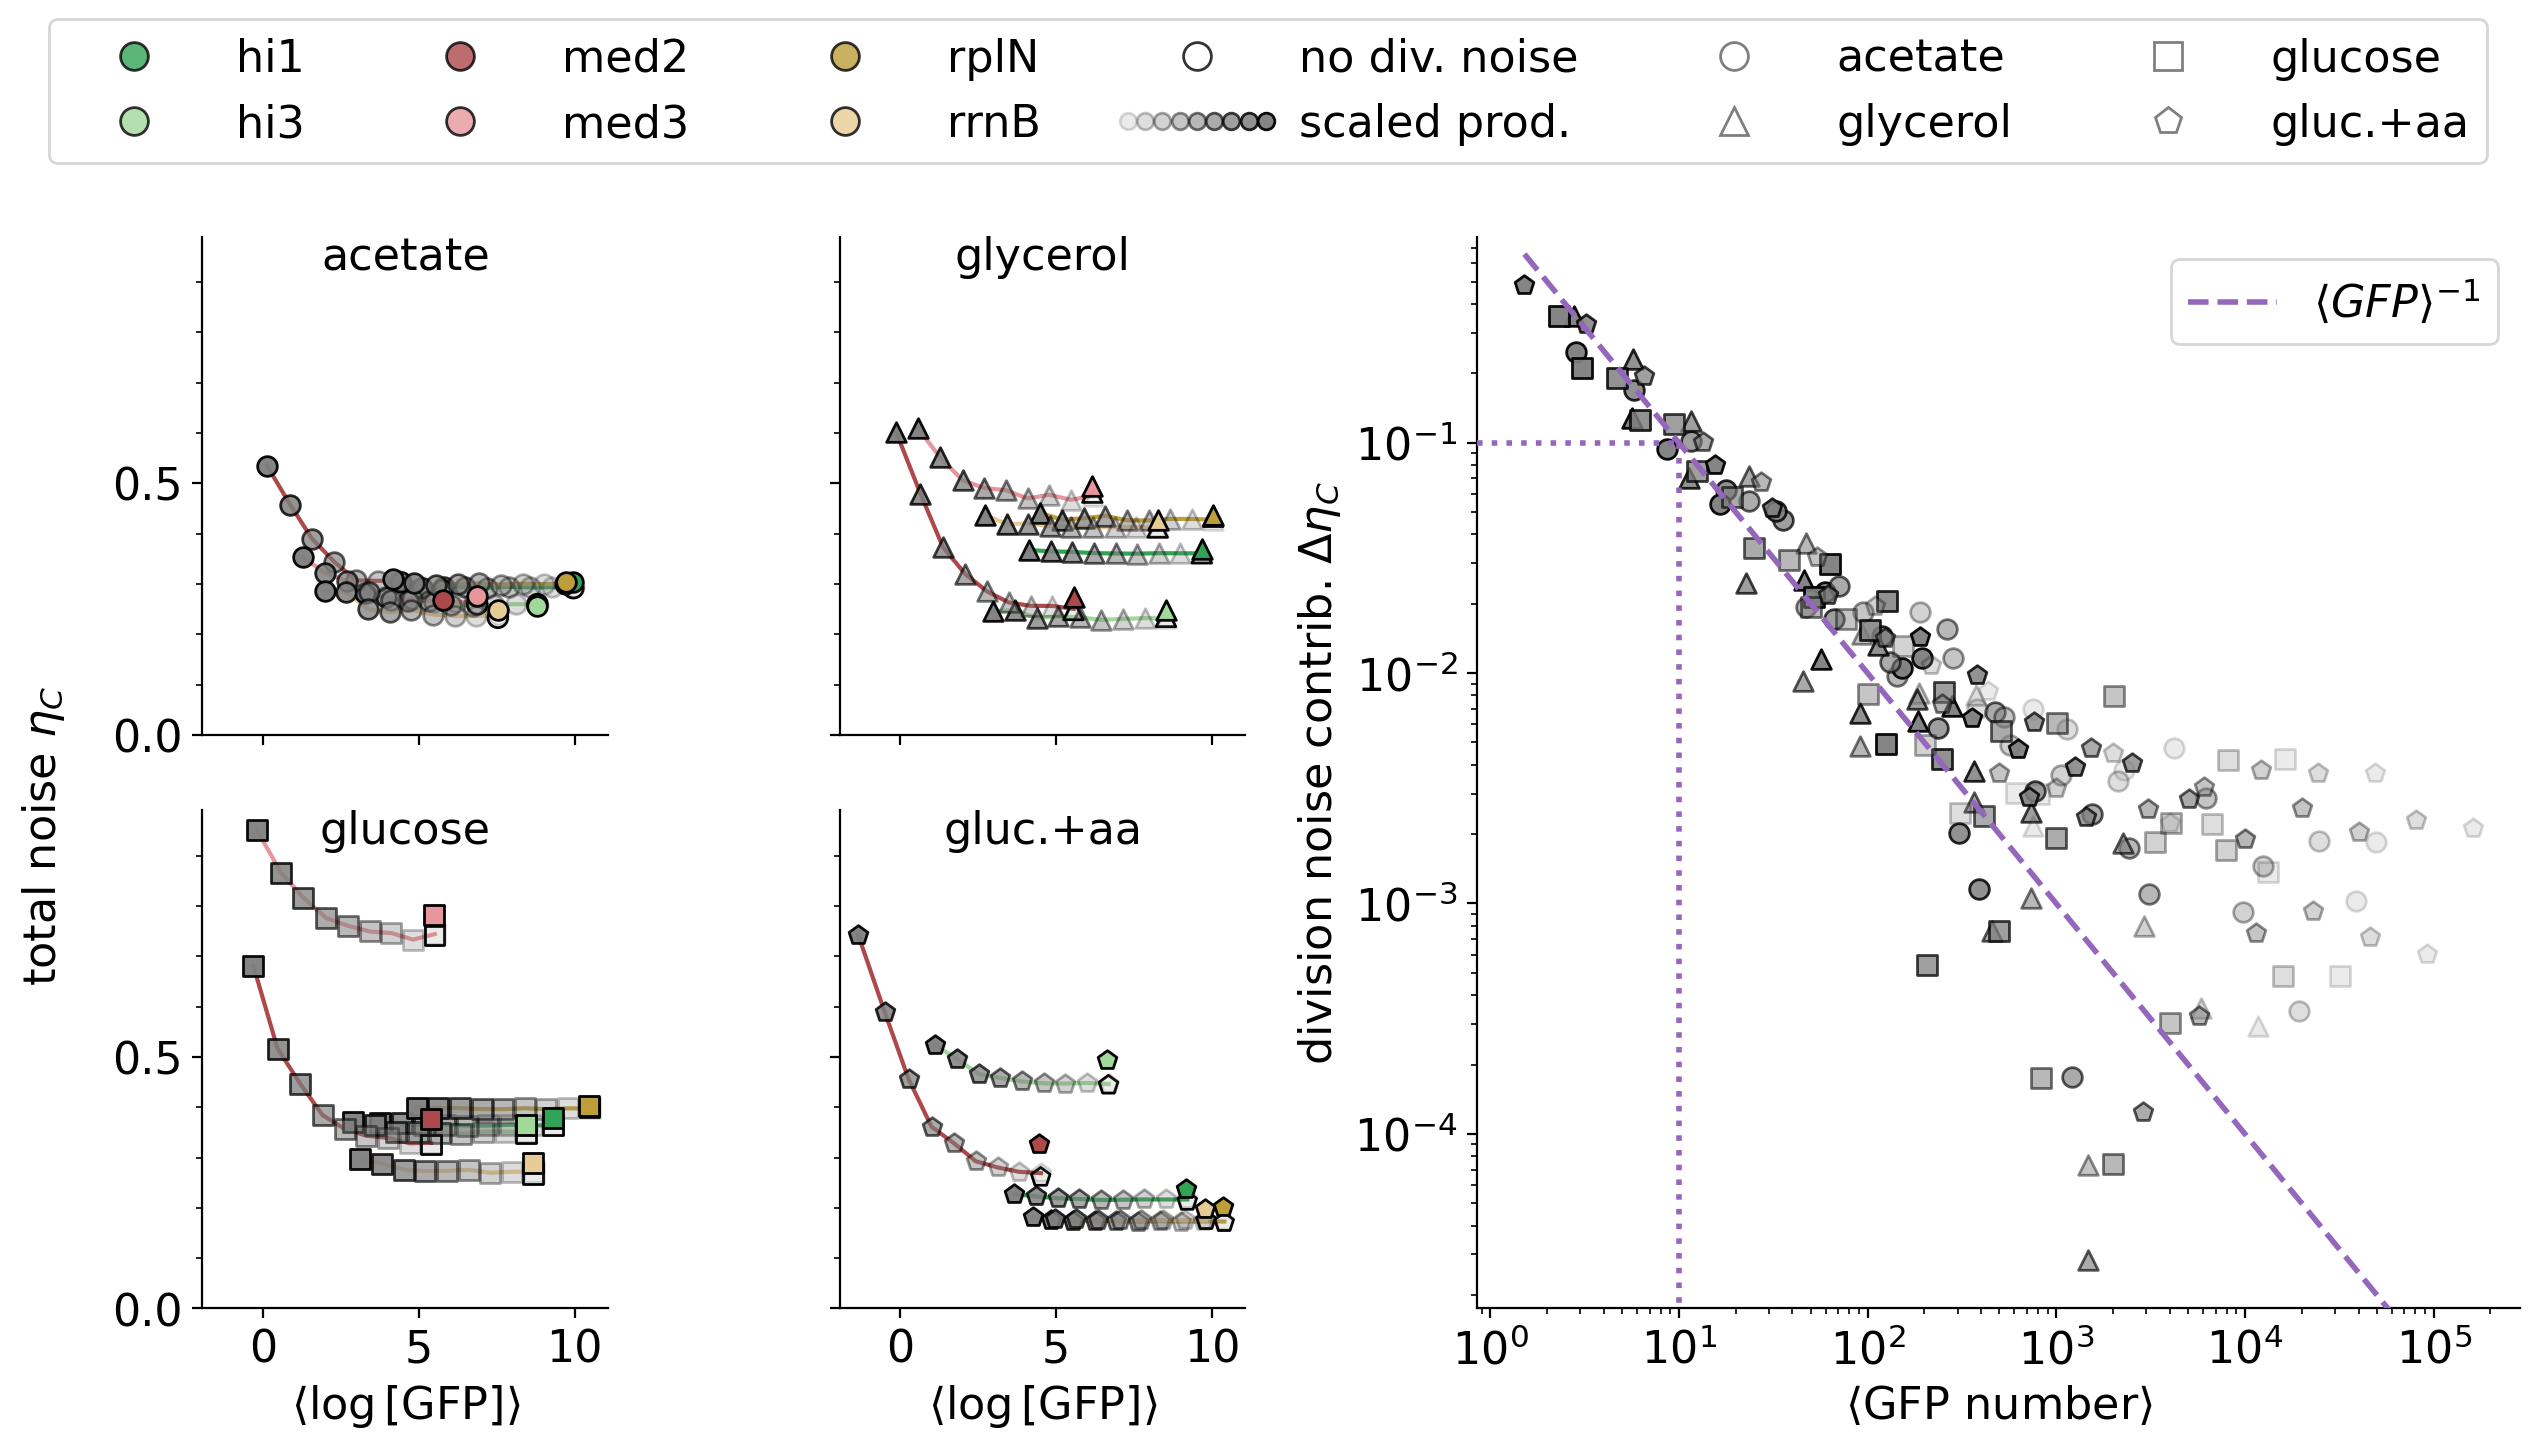

In [13]:
def plot_log_concentration_iqr_both(samples, noise_settings=[], plot_file=None):
    fig, axes = plt.subplots(2, 4, figsize=(FULL_SIZE, FULL_SIZE/2.), sharey=True, sharex=True)
    gs = axes[1, 2].get_gridspec()
    # remove the underlying axes
    for a in axes[:, -2:].ravel():
        a.remove()
    axbig = fig.add_subplot(gs[:, -2:])    
    ax = axes[:, :-2].ravel()

    # axins = axbig.inset_axes([0.7, 0.7, 0.3, 0.3])
    # axins.set_xscale('log')
    # axins.set_yscale("log")
    
    
    for a in list(ax) +[axbig]:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)
        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

    for a in [axbig]:
        a.set_xscale('log')
        a.set_yscale("log")

    
    all_mean_gfp = np.array([])
    all_delta_iqr = np.array([])

    for i, condition in enumerate(conditions):
        for sample in samples.keys():
            if samples[sample]["condition"] != condition:
                continue
            color = color_by_promoter[samples[sample]["promoter"]]
            marker = marker_by_condition[samples[sample]["condition"]]
            ###
           
            if condition == conditions[-1] and samples[sample]["promoter"]=="med3" :
                noise_settings = noise_settings

            else:
                noise_settings = noise_settings
            # noise_settings = noise_settings
            
            iqrs=[]
            log_gfp_means=[]
            log_concentration_mean = []

            for j, s in enumerate(noise_settings):    
                iqrs.append(get_log_concentration_iqr(samples[sample][s]))
                log_gfp_means.append(get_gfp_mean(samples[sample][s]))
                log_concentration_mean.append(get_log_concentration_mean(samples[sample][s]))


            for j, s in enumerate(noise_settings):       
                if j==0:
                    ax[i].scatter(log_concentration_mean[j], iqrs[j], alpha=1,  s=50,
                                  color=color, ec=list(mcolors.to_rgb('black')), marker=marker, zorder=100)
                elif j==1:
                    ax[i].scatter(log_concentration_mean[j], iqrs[j],  s=50,
                                  color="None", ec=list(mcolors.to_rgb('black')), 
                                  label="no div. noise", marker=marker)
                else:
                    ax[i].scatter(log_concentration_mean[j], iqrs[j], alpha=alpha_by_setting[s],  s=50,
                                  color="tab:grey", ec=list(mcolors.to_rgb('black')) + [alpha_by_setting[s]], 
                                   marker=marker) #label=get_q_scale_label(s),
        
            ax[i].plot(log_concentration_mean[2:], iqrs[2:], color=color, alpha=1, zorder=-1, 
                                  label=samples[sample]["promoter"])
            ax[i].set_title(label_by_condition[condition], y=0.9)

            ax[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
            ax[i].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))
            
            #######    
            delta = np.add(iqrs, - iqrs[1])
            all_mean_gfp = np.append(all_mean_gfp, log_gfp_means[2:])
            all_delta_iqr = np.append(all_delta_iqr, delta[2:])
            
            for j, s in enumerate(noise_settings):       
                if j==0:
                    pass
                    # axbig.scatter(log_gfp_means[j], delta[j], alpha=0.8, color=color, 
                                #   ec=list(mcolors.to_rgb('black')) + [0.5], label=samples[sample]["promoter"], marker=marker)
                elif j==1:
                    pass
                    # axbig.scatter(log_gfp_means[j], delta[j], color="None", 
                    #               ec=list(mcolors.to_rgb('black')) + [0.5], label="no div. noise", marker=marker)
                else:
                    axbig.scatter(log_gfp_means[j], delta[j], alpha=alpha_by_setting[s], color="tab:grey", s=50,
                                  ec=list(mcolors.to_rgb('black')) + [0.5],  marker=marker) #label=get_q_scale_label(s),



    g0 = all_delta_iqr>0
    all_mean_gfp = all_mean_gfp[g0]
    all_delta_iqr = all_delta_iqr[g0]

    popt,_ =power_law_fit(all_mean_gfp, all_delta_iqr) 
    xlim =  axbig.get_xlim()
    ylim =  axbig.get_ylim()
    
    
    axbig.plot(all_mean_gfp[np.argsort(all_mean_gfp)], 
           power_law(all_mean_gfp[np.argsort(all_mean_gfp)], 1,1),
           ls='--',
            color="tab:purple",label=r"$\langle GFP \rangle ^{-1}$", lw=2, zorder=10)
    
    # axbig.plot(np.NaN, np.NaN, label="$a=${:.2f}, $b=${:.2f}".format(*popt),color="None")
    # print(popt)
    
    axbig.hlines(1/10, axbig.set_xlim()[0], 10, ls=':', color="tab:purple", lw=2, zorder=10)
    axbig.vlines(10, axbig.set_ylim()[0], 1/10, ls=':', color="tab:purple", lw=2, zorder=10)
    
    
    axbig.legend()
    axbig.set_xlim(xlim)
    axbig.set_ylim(ylim)
    # === Legend ===
    from matplotlib.legend_handler import HandlerTuple

    colors_for_legend2 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color=color_by_promoter[k],alpha=0.8, markersize=10,marker='o',linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]

    colors_for_legend1 = [mlines.Line2D([], [],  alpha=alpha_by_setting[s], 
                                        markersize=6,
                                        marker='o',
                                       linestyle='None',
                                       markeredgecolor=list(mcolors.to_rgb('black')) + [alpha_by_setting[s]], 
                                       color='tab:grey', 
                                       label=get_q_scale_label(s)) for s in noise_settings if s in alpha_by_setting.keys() ]

    colors_for_legend3 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color="None",alpha=0.8, markersize=10,marker='o',linestyle='None',
                                        label=k) for k in ['1']]

    marker_for_legend = [mlines.Line2D([], [], markeredgecolor=list(mcolors.to_rgb('black')), 
                                        color="None", alpha=0.5, marker=marker_by_condition[k], markersize=10, linestyle='None',
                                        label=k) for k in marker_by_condition.keys()]
        
        
    l = fig.legend([tuple(colors_for_legend2[i:i+1]) for i in range(6)] + [tuple(colors_for_legend3[:1])] + [tuple(colors_for_legend1)] +\
                    [tuple(marker_for_legend[0:1]), 
                    tuple(marker_for_legend[1:2]),
                    tuple(marker_for_legend[2:3]),
                    tuple(marker_for_legend[3:4])], 
                    promoters+ ["no div. noise"] + ['scaled prod.'] +[conditions_labels[0], conditions_labels[1], conditions_labels[2], conditions_labels[3]],
                    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", 
                    ncol=6, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], handlelength = 3)   
    
    
    ## Layout ##
    ax[0].set_ylim(0)   

    axbig.set_ylabel(r"division noise contrib. $\Delta \eta_C$")
    ax[2].set_xlabel(r"$\langle \log $[GFP]$ \rangle$")
    ax[3].set_xlabel(r"$\langle \log $[GFP]$ \rangle$")
    
    axbig.set_xlabel(r"$\langle \mathrm{GFP\ number}\rangle$")
    fig.supylabel(r"total noise $\eta_C$")

    ## save ##

    plt.tight_layout()
    # fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()

setting_to_compare = ["cells"]+["cells_"+s for s in ["no_div_noise", "1" , '0.5', '0.25', '0.125', '0.0625', '0.03125', '0.015625', '0.0078125', '0.00390625']]
plot_log_concentration_iqr_both(first_replicates, noise_settings=setting_to_compare[:], 
                                plot_file="../../figures_for_fluctuations_paper/downscaling_IQR.pdf")
